## Лабораторная работа по курсу "Искусственный интеллект"
## Многослойный персептрон

| Студент | Кузьмичев|
|---------|--------|
| Группа  | 6      |

Для начала, скачаем датасет MNIST. Мы будем использовать встроенный в Pytorch датасет 

Добавляем необходимые импорты для работы 

In [18]:
import torch
import torchvision

Опишу класс нейронной сети, следуя инструкциям в лекциях

In [19]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt 
import numpy as np

n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

Теперь объявим датасет, по которому мы будем обучать нейронную сеть

In [20]:
dataloader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             
                             ])),
  batch_size=batch_size_train, shuffle=True)

testloader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                             
                             ])),
  batch_size=batch_size_test, shuffle=True)


Добавим переменные

Покажем, что у нас вышло:

In [21]:
examples = enumerate(testloader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

torch.Size([1000, 1, 28, 28])

In [22]:


n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

Объявим функции, в которых будем тренировать и тестировать нашу нейронную сеть

In [23]:
from sklearn.metrics import confusion_matrix

def train(epoch):
  network.train()
  accuracy_list = []
  for batch_idx, (data, target) in enumerate(dataloader):
    optimizer.zero_grad()
    output = network(data)
    pred = output.data.max(1, keepdim=True)[1]
    accuracy_list.append((pred.eq(target.data.view_as(pred)).sum()/len(target.data)).item())
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(dataloader.dataset)))
  return sum(accuracy_list)/len(accuracy_list), loss.item()

def test():
  accuracy_list = []
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in testloader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
      accuracy = (pred.eq(target.data.view_as(pred)).sum()/len(target.data)).item()
      accuracy_list.append(accuracy)
  test_loss /= len(testloader.dataset)
  test_losses.append(test_loss)
  return (sum(accuracy_list)/len(accuracy_list)), test_loss


def get_confusion_matrix():
  confusion_pred = []
  confusion_true = []
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in testloader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
      confusion_pred += (torch.flatten(pred).tolist())
      confusion_true += (torch.flatten(target.data).tolist())
  test_loss /= len(testloader.dataset)
  test_losses.append(test_loss)
  return confusion_pred, confusion_true

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dis

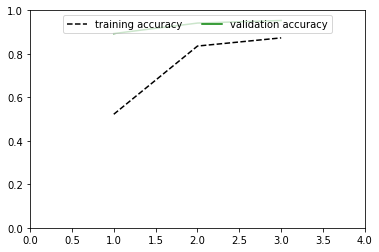

In [24]:
def plot_training_progress(x, y_data, fig, ax):
  styles = ['k--', 'g-']
        # remove previous plot
  while ax.lines:
    ax.lines.pop()
  # draw updated lines
  for i in range(len(y_data)):
    ax.plot(x, y_data[i], styles[i])
  ax.legend(ax.lines, ['training accuracy', 'validation accuracy'],
              loc='upper center', ncol = 2)

train_losses = []
train_counter = []
test_losses = []
accuracy_test = []
accuracy_train = []
test_counter = [i*len(dataloader.dataset) for i in range(n_epochs + 1)]
test()
fig, ax = plt.subplots(1, 1)
ax.set_xlim(0, n_epochs + 1)
ax.set_ylim(0,1)
train_acc = np.empty((n_epochs, 3))
train_acc[:] = np.NAN
valid_acc = np.empty((n_epochs, 3))
valid_acc[:] = np.NAN
for epoch in range(1, n_epochs + 1):
  taccuracy, tloss = train(epoch)
  vaccuracy, vloss = test()
  train_acc[epoch-1, :] = [epoch, tloss, taccuracy]
  valid_acc[epoch-1, :] = [epoch, vloss, vaccuracy]
  plot_training_progress(train_acc[:, 0], (train_acc[:, 2],
                                                 valid_acc[:, 2]), fig, ax)
  fig.canvas.draw()
  fig.canvas.flush_events()



Теперь построим график функции потерь по нашему обучению:


Text(0, 0.5, 'negative log likelihood loss')

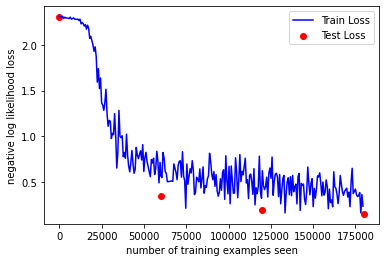

In [25]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='green')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

Таким образом я увидел, что pyTorch уже содержит базовые наборы данных, содержит базовые конструкции для нейросетей, и с помощью него можно быстро реализовать персептрон. Базовые датасеты можно быстро и легко научить распознавать с довольно высокой точностью